In [12]:
# CSCI 580 - Final Project: MNIST MLP and Custom Handwritten Digits


# **Main parts:**
# 1. Load MNIST and define transforms
# 2. Define and train an MLP on MNIST
# 3. Evaluate the trained MLP on MNIST test set
# 4. Load class handwritten PNG digits (Task 2)
# 5. Apply preprocessing with PyTorch transforms (Task 3)
# 6. Evaluate MLP on class digits and report accuracy


In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [14]:
# Transform for MNIST: [0, 255] -> [0, 1] -> [-1, 1]
mnist_transform = transforms.Compose([
    transforms.ToTensor(),                 # [0, 255] -> [0, 1]
    transforms.Normalize((0.5,), (0.5,))   # [0, 1] -> [-1, 1]
])

# MNIST training set
trainset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=mnist_transform
)

# MNIST test set
testset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=mnist_transform
)

batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print("Number of training samples:", len(trainset))
print("Number of test samples:", len(testset))
print("Number of training batches:", len(trainloader))
print("Number of test batches:", len(testloader))

# Quick sanity check on shapes
images, labels = next(iter(trainloader))
print("Batch images shape:", images.shape)   # (B, 1, 28, 28)
print("Batch labels shape:", labels.shape)   # (B,)


Number of training samples: 60000
Number of test samples: 10000
Number of training batches: 938
Number of test batches: 157
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [15]:
class MLP(nn.Module):
    # to change parameters easier
    def __init__(self, input_size=784, hidden1=128, hidden2=64, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # x shape: (B, 1, 28, 28) - flatten to (B, 784)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.fc3(x)  # raw scores
        return logits

model = MLP().to(device)
print(model)


MLP(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def train_mlp(model, trainloader, epochs=5):
    model.train()
    all_epoch_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels in trainloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        all_epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return all_epoch_losses


Epoch 1/15, Loss: 1.0314
Epoch 2/15, Loss: 0.3828
Epoch 3/15, Loss: 0.3221
Epoch 4/15, Loss: 0.2881
Epoch 5/15, Loss: 0.2625
Epoch 6/15, Loss: 0.2404
Epoch 7/15, Loss: 0.2210
Epoch 8/15, Loss: 0.2040
Epoch 9/15, Loss: 0.1888
Epoch 10/15, Loss: 0.1762
Epoch 11/15, Loss: 0.1645
Epoch 12/15, Loss: 0.1545
Epoch 13/15, Loss: 0.1454
Epoch 14/15, Loss: 0.1372
Epoch 15/15, Loss: 0.1297


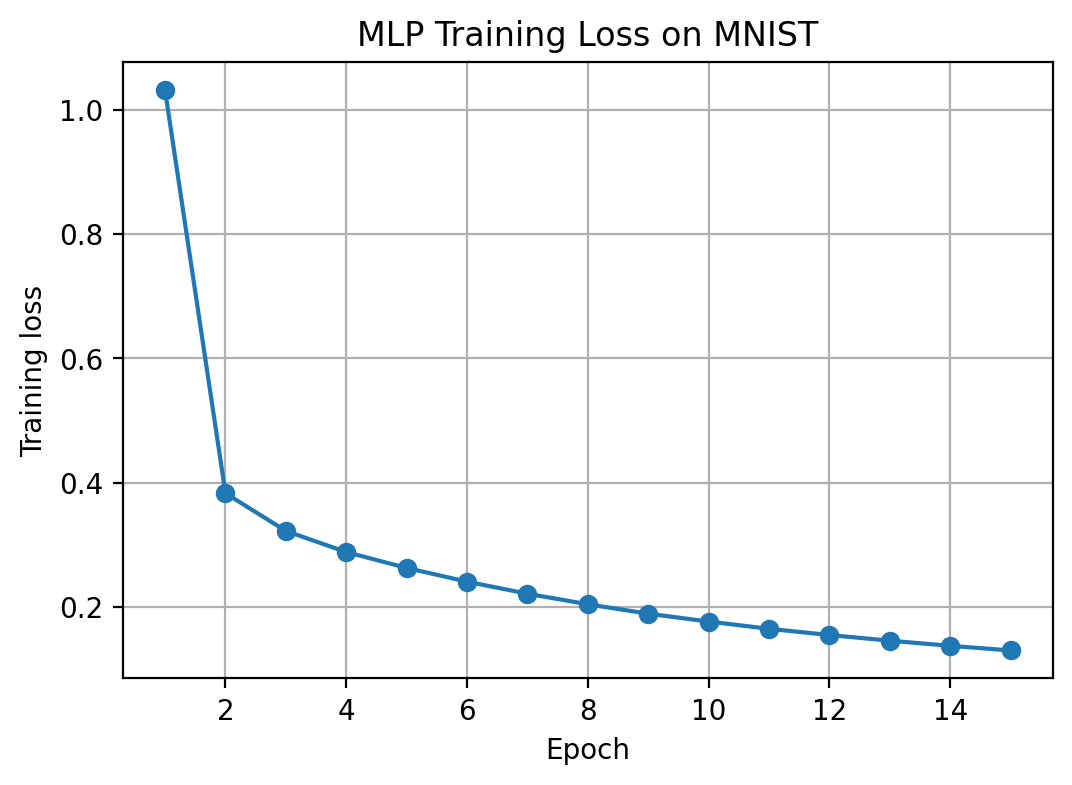

In [17]:
epochs = 15  # you can increase later for better performance

losses = train_mlp(model, trainloader, epochs=epochs)

# Plot training loss per epoch
plt.figure(figsize=(6, 4))
plt.plot(range(1, epochs + 1), losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("MLP Training Loss on MNIST")
plt.grid(True)
plt.show()


In [18]:
def evaluate_on_mnist(model, testloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy on MNIST test set: {accuracy:.4f}")
    return accuracy

mnist_test_accuracy = evaluate_on_mnist(model, testloader)


Accuracy on MNIST test set: 0.9571


In [19]:
def ProjectDataLoader(root_dir="../digits"):
    """
    Reads all PNG images from root_dir
    Returns:
        images: array of shape (N, 28, 28), dtype uint8
        labels: array of shape (N,), dtype int64
    """
    image_list = []
    label_list = []

    if not os.path.isdir(root_dir):
        raise RuntimeError(f"Directory not found: {root_dir}")

    for fname in sorted(os.listdir(root_dir)):
        if not fname.lower().endswith(".png"):
            continue

        # Parse label from filename prefix
        try:
            digit_str = fname.split("-")[0]
            label = int(digit_str)
        except ValueError:
            print(f"Skipping file with unexpected name format: {fname}")
            continue

        fpath = os.path.join(root_dir, fname)

        # Open as grayscale
        img = Image.open(fpath).convert("L")
        # Make sure size is 28 x 28
        img = img.resize((28, 28))

        img_np = np.array(img, dtype=np.uint8)  # [0, 255]
        image_list.append(img_np)
        label_list.append(label)

    if len(image_list) == 0:
        raise RuntimeError(f"No PNG images found in {root_dir}")

    images = np.stack(image_list, axis=0)           # (N, 28, 28)
    labels = np.array(label_list, dtype=np.int64)   # (N,)

    print(f"Loaded {images.shape[0]}")
    return images, labels

class_digits_dir = "../digits"  # change this to match

# Try loading 
images_np, labels_np = ProjectDataLoader(class_digits_dir)
print(images_np.shape, labels_np.shape)


Loaded 330
(330, 28, 28) (330,)


In [20]:
# Transform for custom digits, same as MNIST
digit_transform = transforms.Compose([
    transforms.ToTensor(), # [0, 255] -> [0, 1], shape (1, 28, 28)
    transforms.Normalize((0.5,), (0.5,)) # [0, 1] -> [-1, 1]
])

class CustomDigitsDataset(Dataset):
    def __init__(self, images_np, labels_np, transform=None):
        assert images_np.shape[0] == labels_np.shape[0]
        self.images = images_np
        self.labels = labels_np
        self.transform = transform

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        img_np = self.images[idx] # shape (28, 28), uint8
        label = int(self.labels[idx])

        # convert to PIL image
        img_pil = Image.fromarray(img_np, mode="L")

        if self.transform is not None:
            img_tensor = self.transform(img_pil)   # (1, 28, 28), float32 in [-1, 1]
        else:
            img_tensor = torch.from_numpy(img_np).unsqueeze(0).float() / 255.0

        return img_tensor, label


In [21]:
# Load class digits from PNGs
images_np, labels_np = ProjectDataLoader(class_digits_dir)

project_dataset = CustomDigitsDataset(images_np, labels_np, transform=digit_transform)

project_loader = DataLoader(
    project_dataset,
    batch_size=64,
    shuffle=False
)




Loaded 330


In [22]:
def evaluate_on_custom_digits(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)             # model flattens internally
            preds = logits.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"Accuracy on class handwritten digits: {accuracy:.4f}")
    return accuracy

custom_accuracy = evaluate_on_custom_digits(model, project_loader)


Accuracy on class handwritten digits: 0.5727


/var/folders/nl/7l97t_l54rbfd_8_fj5qqfp40000gn/T/ipykernel_51492/2772472433.py:22: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray(img_np, mode="L")
